In [1]:
from src.dispersion import * 
from src.VSH import * 
from src.extra_special import * 
from src.fields import (
    E_,
    H_,
    E_cart_,
    H_cart_
)
from src.AM import *

import numpy as np
import scipy.constants as const
import scipy.special as sp
from scipy import integrate
from scipy.misc import derivative
from cxroots import Rectangle, AnnulusSector, Circle
import cxroots
from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe  # for text effects 
plt.rcParams.update({'font.size': 18})

Z_0 = np.sqrt(const.mu_0 / const.epsilon_0)  # vacuum impedance

Let us calculate 
$$
[\mathbf{j}^2] = \frac{\langle \psi | \hat{\mathbf{J}}^2 | \psi \rangle}{\langle \psi |\psi \rangle}
$$
for $\psi$ being just a VSH.

In [116]:
def cart2sph(x, y, z):
    """
        https://en.wikipedia.org/wiki/Spherical_coordinate_system#Cartesian_coordinates
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)  # [0, π]
    phi = np.arctan2(y, x)  # [0, 2π]
    return r, theta, phi

def sph2cart(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta) 
    return x, y, z


def rotationMatrixSph(theta, phi):
    """
        A^cart = R(theta, phi) A^sph
    """
    return np.array([
        [np.sin(theta)*np.cos(phi), np.cos(theta)*np.cos(phi), -np.sin(phi)],
        [np.sin(theta)*np.sin(phi), np.cos(theta)*np.sin(phi),  np.cos(phi)],
        [            np.cos(theta),            -np.sin(theta),            0]
    ])

def rotationMatrixCyl3D(phi, axis='z'):
    """
        https://en.wikipedia.org/wiki/Rotation_matrix#In_three_dimensions
        A^cart = R(phi) A^sph
    """
    if axis == 'x':
        return np.array([
            [1,           0,            0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi),  np.cos(phi)]
        ])
    elif axis == 'y':
        return np.array([
            [ np.cos(phi), 0, np.sin(phi)],
            [           0, 1,           0],
            [-np.sin(phi), 0, np.cos(phi)]
        ])
    elif axis == 'z':
        return np.array([
            [np.cos(phi), -np.sin(phi), 0],
            [np.sin(phi),  np.cos(phi), 0],
            [          0,            0, 1]
        ])
    else:
        raise NameError('Invalid axis!')


def fieldTrasformSph2cart(Asph, args=()):
    """
        Asph(r, θ, φ) --- vector field in spherical coord basis
        
        returns Acart(x, y, z) --- vector field function in cartesian coord basis
    """
    def Acart(x, y, z):
        r, theta, phi = cart2sph(x, y, z)
        R = rotationMatrixSph(theta, phi)  # A^cart = R(theta, phi) A^sph
        return R @ Asph(r, theta, phi, *args)
    
    return Acart
    

In [161]:
def Asph(r, theta, phi):
    return np.array([
        r, 1j*r*np.cos(theta), 0
    ])

Acart = fieldTrasformSph2cart(Asph)

In [162]:
x, y, z = 2, 3, 1
r, theta, phi = cart2sph(x, y, z)

ic(
    np.linalg.norm(Acart(x, y, z))**2,
    np.linalg.norm(Asph(r, theta, phi))**2
);

ic| np.linalg.norm(Acart(x, y, z))**2: 15.000000000000002
    np.linalg.norm(Asph(r, theta, phi))**2: 15.000000000000002


In [5]:
def D(foo, x, y, z, variables='nan', dh=1e-5, order=3):
    def d3(foo, x, y, z, var='nan', n=1):
        dd = np.nan
        if var == 'x':
            dd = derivative(lambda x: foo(x, y, z), x, dx=dh, order=order, n=n)
        elif var == 'y':
            dd = derivative(lambda y: foo(x, y, z), y, dx=dh, order=order, n=n)
        elif var == 'z':
            dd = derivative(lambda z: foo(x, y, z), z, dx=dh, order=order, n=n)
    
        return dd
    
    if len(variables) == 1:
        return d3(foo, x, y, z, var=variables)
    elif len(variables) == 2:
        if variables[0] == variables[1]:
            """
                For the case of xx, yy, zz
                use second order derivative from scipy (parameter n=2)
                https://github.com/scipy/scipy/blob/v1.7.1/scipy/misc/common.py#L75-L145
            """
            return d3(foo, x, y, z, var=variables[0], n=2)
        else:
            return d3(
                lambda x, y, z: d3(foo, x, y, z, var=variables[0]), 
                x, y, z, 
                var=variables[1]
            )

In [7]:
def f(x, y, z):
    return np.array([x**2 + x*y*z, x**3])

x, y, z = np.array([1, 1, 1])

D(f, x,y,z, 'xy', dh=1e-5, order=3)

array([1.00000008, 0.        ])

In [252]:
def j2_canonical(x, y, z, fE, fH, part="both", dh=1e-5):
    """
        Electric and magnetic field functions are expected to be
            fE = fE(x, y, z)
            fH = fH(x, y, z)
    """
    factor_el = 1
    factor_mag = 1
    if part == "electric":
        factor_mag = 0
    if part == "magnetic":
        factor_el = 0
    
    E, H = fE(x, y, z), fH(x, y, z)
    dx_E, dx_H = D(fE, x, y, z, 'x'), D(fH, x, y, z, 'x')
    dy_E, dy_H = D(fE, x, y, z, 'y'), D(fH, x, y, z, 'y')
    dz_E, dz_H = D(fE, x, y, z, 'z'), D(fH, x, y, z, 'z')
    
    ddxx_E, ddxx_H = D(fE, x, y, z, 'xx'), D(fH, x, y, z, 'xx')
    ddyy_E, ddyy_H = D(fE, x, y, z, 'yy'), D(fH, x, y, z, 'yy')
    ddzz_E, ddzz_H = D(fE, x, y, z, 'zz'), D(fH, x, y, z, 'zz')
    
    ddxy_E, ddxy_H = D(fE, x, y, z, 'xy'), D(fH, x, y, z, 'xy')
    ddxz_E, ddxz_H = D(fE, x, y, z, 'xz'), D(fH, x, y, z, 'xz')
    ddzy_E, ddzy_H = D(fE, x, y, z, 'zy'), D(fH, x, y, z, 'zy')
    
    ELECTRIC_PART = (
        2 * np.dot(np.conjugate(E), E)
        - np.dot(
            np.conjugate(E),
            2*x*y*ddxy_E + 2*y*z*ddzy_E + 2*z*x*ddxz_E - (y*y+z*z)*ddxx_E - (x*x+z*z)*ddyy_E - (x*x+y*y)*ddzz_E
        )
        + 2j * np.dot(
            np.array([x, y, z]),
            np.conjugate(E[0])*dx_E + np.conjugate(E[1])*dy_E + np.conjugate(E[2])*dz_E
        )
    )

    MAGNETIC_PART = (
        2 * np.dot(np.conjugate(H), H)
        - np.dot(
            np.conjugate(H),
            2*x*y*ddxy_H + 2*y*z*ddzy_H + 2*z*x*ddxz_H - (y*y+z*z)*ddxx_H - (x*x+z*z)*ddyy_H - (x*x+y*y)*ddzz_H
        )
        + 2j * np.dot(
            np.array([x, y, z]),
            np.conjugate(H[0])*dx_H + np.conjugate(H[1])*dy_H + np.conjugate(H[2])*dz_H
        )
    )

    return (factor_el * ELECTRIC_PART + factor_mag * MAGNETIC_PART) / (factor_el*np.linalg.norm(E)**2 + factor_mag*np.linalg.norm(H)**2)

In [256]:
m, n = 0, 3

r, theta, phi = 1, 0.5, 3
x, y, z = sph2cart(r, theta, phi)

# TE mode
E_cart = fieldTrasformSph2cart(lambda r, theta, phi: Mmn(m, n, r, theta, phi, superscript=1))
#E_cart = fieldTrasformSph2cart(lambda r, theta, phi: Xmn_Jackson(m, n, r, theta, phi))
H_cart = fieldTrasformSph2cart(lambda r, theta, phi: -1j * Nmn(m, n, r, theta, phi, superscript=1))

j2 = j2_canonical(x, y, z, E_cart, H_cart, part="magnetic", dh=1e-4)
ic(
    np.real(j2),
    np.imag(j2),
    n*(n+1)
);

ic| np.real(j2): -0.23542220943100853
    np.imag(j2): 4.077756899888371
    n*(n+1): 12


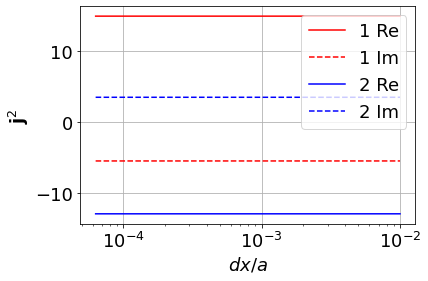

ic| (n+1)*(n+2): 20
    n*(n+1): 12
    m**2: 1
    (m+1)**2: 4
    np.real(j2canon)[0]: 14.986194787219512
    np.imag(j2canon)[0]: -5.505515618307019
    np.real(j2canon2)[0]: -12.986193140923866
    np.imag(j2canon2)[0]: 3.5055144621855914


In [4]:
eps_dielectric = 10 + 0.0j
mu_dielectric = 1.0 + 0.0j
eps_out = 1
mu_out = 1

a = 1
omega = 2*const.speed_of_light

n, m = 3, 1
#m = 1

mode_type = "TE"
particle_type = "dielectric"

r = 2.1*a
theta = 1.2
phi = 1.0

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta) 

epshSpace = 10.0**np.linspace(-4.2, stop=-2, num=7)
j2canon = np.zeros(np.size(epshSpace)) + 0.0j
j2canon2 = np.zeros(np.size(epshSpace)) + 0.0j

part = "electric"


for (i, epsh) in enumerate(epshSpace):
    J2canon = J2_canonical_(
        m, n, x, y, z, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part, epsh=epsh
    )
    J2canon2 = J2_canonical2_(
        m, n, x, y, z, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part, epsh=epsh
    )
    W = W_(
        m, n, r, theta, phi, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part
    )
    j2canon[i] = J2canon / (W/np.abs(omega))
    j2canon2[i] = J2canon2 / (W/np.abs(omega))


plt.plot(epshSpace, np.real(j2canon), c="red", label="1 Re")
plt.plot(epshSpace, np.imag(j2canon), c="red", ls="--", label="1 Im")

plt.plot(epshSpace, np.real(j2canon2), c="blue", label="2 Re")
plt.plot(epshSpace, np.imag(j2canon2), c="blue", ls="--", label="2 Im")

plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.ylabel("$\mathbf{j}^2$")
plt.xlabel("$dx/a$")
plt.grid()
#plt.ylim(0, 12)
plt.show()


ic(
    (n+1)*(n+2),
    n*(n+1),
    m**2,
    (m+1)**2,
    np.real(j2canon)[0], 
    np.imag(j2canon)[0],
    np.real(j2canon2)[0], 
    np.imag(j2canon2)[0]
);